## Data Exploration

In [ ]:

s3_bucket_path="s3://aegovan-data/human_output/human_keyinteractions.json"


In [ ]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [31]:
data_file="input_data.json"


In [ ]:
download_single_file(s3_bucket_path, data_file)

In [32]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


### Sneak preview of the data

In [ ]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)

In [ ]:
data.head(n=3)

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

In [ ]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

In [ ]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [ ]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


In [ ]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [ ]:
data = data.query("lessThanThreshold == 1")

In [ ]:
print("Total number of records after filter: {}".format(data.shape[0]))

### Interaction Types distribution

In [ ]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Interaction Type Distribution')
plt.show()

In [ ]:
data.interactionType.value_counts().to_frame()

### Distinct interaction types per paper

In [ ]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

In [ ]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

In [ ]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [ ]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

In [ ]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [ ]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [ ]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

In [ ]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

In [ ]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


In [ ]:
data.head(n=10)

### Data Transformation

In [41]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(data)


In [42]:
data_transformed.head(n=2)

,destAlias,destUnitprot,interactionId,interactionType,isNegative,pubmedId,pubmedTitle,pubmedabstract,sourceAlias,sourceUniprot
0,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405,2503510,phosphorylation,false,25605870,None,NLRP3 is the most crucial member of the NLR fa...,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405
1,"[[asc_human], [Apoptosis-associated speck-like...",Q9BSZ5,2503513,phosphorylation,false,25605870,None,NLRP3 is the most crucial member of the NLR fa...,"[[ksyk_human], [Tyrosine-protein kinase SYK], ...",P43405


In [43]:
data_transformed.shape

(5510, 10)

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [35]:

def generate_negative(data):
    import uuid
    unique_pubmeds = data["pubmedId"].unique()
    data_fake = pd.DataFrame(columns=data.columns)

    num_fake_records = int( .50 * len(data))
    #TODO: Randomise this, biased via
    for u in unique_pubmeds:
        fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
        fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
        fake_records.loc[:,"isNegative"] = 'True' 
        ## Copy of the pubmeid abtract and the title from a id
        fake_records.loc[:,"pubmedId"] = u
        fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
        fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


        data_fake = data_fake.append(fake_records, ignore_index=True)
        if len(data_fake) > num_fake_records:
            break
            
    return data_fake
  
    

In [45]:
data_filtered = data_transformed[data_transformed.sourceAlias.notnull()]
data_filtered = data_filtered[data_filtered.destAlias.notnull()]

In [46]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_filtered, test_size=.2,
                                                        random_state=777)

train, val = train_test_split(train, test_size=.2,
                                                        random_state=777)

In [47]:
train = train.append(generate_negative(train), ignore_index=True)
print("The total number of train records including fake records {}".format(train.shape[0]))


test = test.append(generate_negative(test), ignore_index=True)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = test.append(generate_negative(val), ignore_index=True)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of train records including fake records 3745
The total number of test records including fake records 1285
The total number of test records including fake records 1565


In [48]:
train.sort_values(by=["pubmedId"]).query("interactionType != 'phosphorylation'").head(n=10)

,destAlias,destUnitprot,interactionId,interactionType,isNegative,pubmedId,pubmedTitle,pubmedabstract,sourceAlias,sourceUniprot
3396,"[[ub2v1_human], [Ubiquitin-conjugating enzyme ...",Q9UM48,1572512_b8163f77-b235-4d1f-bad0-7b372b4c4663_fake,ubiquitination,True,2153075,None,"Some genital human papillomavirus (HPV) types,...","[[uba1_human], [Ubiquitin-like modifier-activa...",Q5JRR8
3446,"[[ptprc_human], [Receptor-type tyrosine-protei...",A0A0A0MT22,824757_e3375c3d-9bc9-46ec-a486-f2df515dda3b_fake,dephosphorylation,True,7514173,None,The enzyme glycogen synthase kinase-3 (GSK-3) ...,"[[ntrk1_human], [High affinity nerve growth fa...",B7ZM34
1140,"[[ptn1_human], [Tyrosine-protein phosphatase n...",Q5TGD8,794415,dephosphorylation,false,7514173,None,The enzyme glycogen synthase kinase-3 (GSK-3) ...,"[[gsk3b_human], [Glycogen synthase kinase-3 be...",Q9UL47
3575,"[[met_human], [Hepatocyte growth factor recept...",Q9UDX7,1242450_09ee024d-a7ea-4716-b092-d07763af1941_fake,dephosphorylation,True,7539106,None,Its reactivity to the antiphosphotyrosine 4G10...,"[[ppbi_bovin], [Intestinal-type alkaline phosp...",Q28124
1903,"[[ptn6_human], [Tyrosine-protein phosphatase n...",G3V0F8,794427,dephosphorylation,false,7539106,None,Its reactivity to the antiphosphotyrosine 4G10...,"[[esr1_human], [Estrogen receptor], [ESR1], [E...",Q14276
3430,"[[ub2v1_human], [Ubiquitin-conjugating enzyme ...",Q9UM48,1572642_5e53acd2-aff5-40c8-94a2-f3b17ffe8faa_fake,ubiquitination,True,7685104,None,The substrate specificity of a recombinant pro...,"[[ube2n_human], [Ubiquitin-conjugating enzyme ...",Q16781
3255,"[[kdm4a_human], [Lysine-specific demethylase 4...",Q5VVB1,680731_fc27a4e4-17f5-4460-bbf7-784bb8a153fc_fake,demethylation,True,7782287,None,Mammalian pyruvate dehydrogenase (alpha 2 beta...,"[[h31t_human], [Histone H3.1t], [HIST3H3], [H3...",B2R5K3
720,"[[pdp1_human], [[Pyruvate dehydrogenase [acety...",B3KX71,1242866,dephosphorylation,false,7782287,None,Mammalian pyruvate dehydrogenase (alpha 2 beta...,"[[odpa_human], [Pyruvate dehydrogenase E1 comp...",Q9UBJ8
3375,"[[csk_human], [Tyrosine-protein kinase CSK], [...",Q6FGZ6,824736_2b6fdf50-22bd-4df7-bff9-a56d4e963a10_fake,dephosphorylation,True,8114715,None,The phosphorylation and dephosphorylation of p...,"[[ptprc_human], [Receptor-type tyrosine-protei...",A0A0A0MT22
3439,"[[cop1_arath], [E3 ubiquitin-protein ligase CO...",O23975,699351_b07c44ea-0efa-4fa8-95b2-dfa5c1dc7f2e_fake,ubiquitination,True,8521818,None,It is proposed that the CDK7-cyclin H complex ...,"[[hfr1_arath], [Transcription factor HFR1], [T...",Q9FZ26


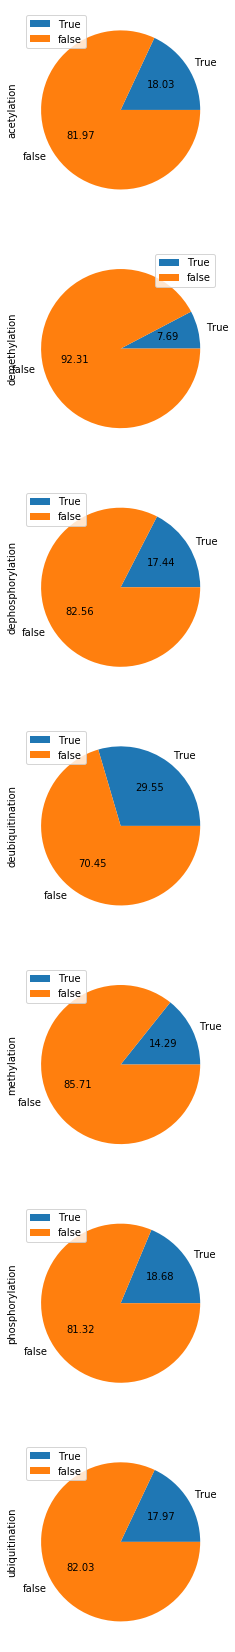

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 7,1, figsize=(45,30))
train.groupby(['isNegative', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

In [50]:
train.to_json("train.json")
test.to_json("test.json")
val.to_json("val.json")